# AR Model parameter estimation

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf as sm_acf
from statsmodels.tsa.stattools import acf as sm_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [129]:
def ar(phi, size=100, sd=1):
    p = len(phi)
    phi = np.array(phi)
    noise = np.random.normal(size=size, scale=sd)
    x = np.zeros(size)
    for i in range(p, size):
        x[i] = (phi * np.flip(x[(i-p):i])).sum() + noise[i]
    return x

def autocov(x, k):
    x = np.array(x)
    assert k < x.size
    n = x.size
    mu_x = np.mean(x)
    gamma = np.mean((x[:n-k] - mu_x) * (x[k:] - mu_x))
    return gamma

def autocor(x, k):
    return autocov(x, k)/autocov(x, 0)

def autocor_func(x, nlags=20):
    x = np.array(x)
    nlags = min(x.size-1, nlags)
    return np.array([autocor(x, k) for k in range(nlags+1)])

def compute_R_matrix(acf, p):
    R = np.zeros(shape=(p,p))
    for i in range(p):
        R[i, :] = np.concatenate([np.flip(acf[0:i-1+2]), acf[1:p-i]])
    return R

def compute_b_vector(acf, p):
    b = acf[1:p+1]
    return b

def fit_ar(data, p, acf_func=sm_acf):
    acf = acf_func(data, nlags=p)
    R = compute_R_matrix(acf, p)
    b = compute_b_vector(acf, p)
    phi_hat = np.linalg.solve(R, b)
    return phi_hat

def estimate_var(data, phi_hat, acf_func=sm_acf):
    gamma_0 = autocov(data, 0)
    r = acf_func(data, nlags=phi_hat.size)
    phi_times_r_sum = (phi_hat*r[1:]).sum()
    var_hat = gamma_0 * (1-phi_times_r_sum)
    return var_hat

In [15]:
phi = [1/3, 1/2, 7/100, -1/10, 1/1000]
n = 10000
sd = 4
phi = np.array(phi)


<ipython-input-16-9db0e549ff25>:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(autocor_func(ar_proc))


<StemContainer object of 3 artists>

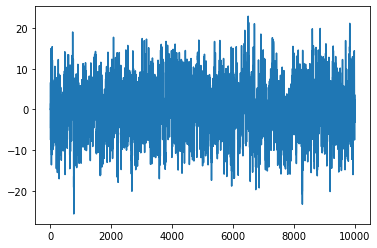

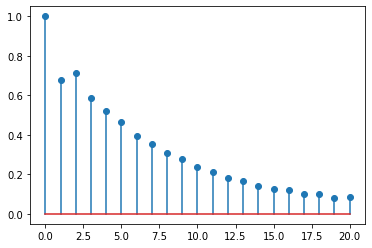

In [16]:
# Simulate AR process
np.random.seed(123)
ar_proc = ar(phi, n, sd=sd)
plt.figure()
plt.plot(ar_proc)
plt.figure()
plt.stem(autocor_func(ar_proc))

[[1.         0.6759092  0.7151173  0.58571514 0.51813376]
 [0.6759092  1.         0.6759092  0.7151173  0.58571514]
 [0.7151173  0.6759092  1.         0.6759092  0.7151173 ]
 [0.58571514 0.7151173  0.6759092  1.         0.6759092 ]
 [0.51813376 0.58571514 0.7151173  0.6759092  1.        ]] 

[0.6759092  0.7151173  0.58571514 0.51813376 0.46414516] 

[ 0.34560035  0.50245059  0.04472118 -0.0846613   0.0160275 ]


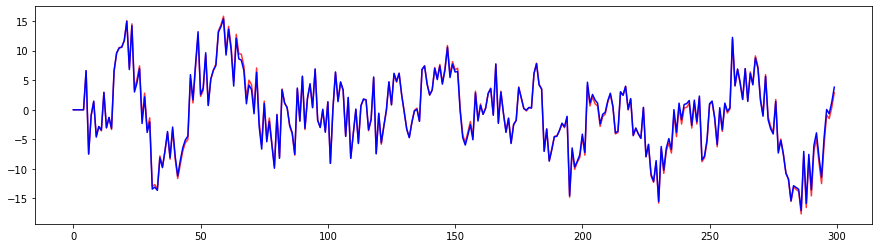

In [17]:
R = compute_R_matrix(autocor_func(ar_proc), p=phi.size); print(R, '\n')
b = compute_b_vector(autocor_func(ar_proc), p=phi.size); print(b, '\n')
phi_hat = np.linalg.solve(R, b); print(phi_hat)

np.random.seed(123)
est_ar_proc = ar(phi_hat.reshape(-1), 10000, sd=sd)
plt.figure(figsize=(15,4))
rng = 300
plt.plot(est_ar_proc[0:rng], c='r', label='estimated', alpha=0.8)
plt.plot(ar_proc[0:rng], c='b', label='true proc')

In [18]:
var_hat = estimate_var(ar_proc, phi_hat);print(var_hat)

15.905885258533148


# Modeling Recruitment

In [19]:
rec = pd.read_csv("recruitment.csv", index_col=0)

rec.head()

,time,rec
1,1950.000000,68.63
2,1950.083333,68.63
3,1950.166667,68.63
4,1950.250000,68.63
5,1950.333333,68.63


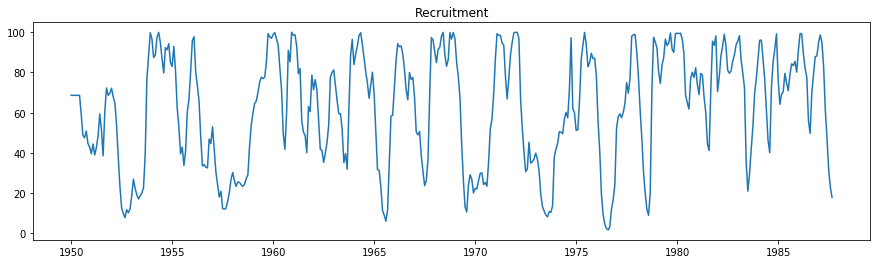

In [25]:
ax = plt.figure(figsize=(15,4)).gca()
ax.plot(rec.time, rec.rec)
ax.set_title('Recruitment')
plt.show()

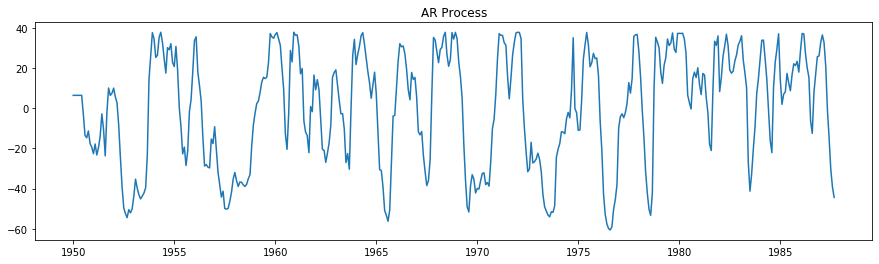

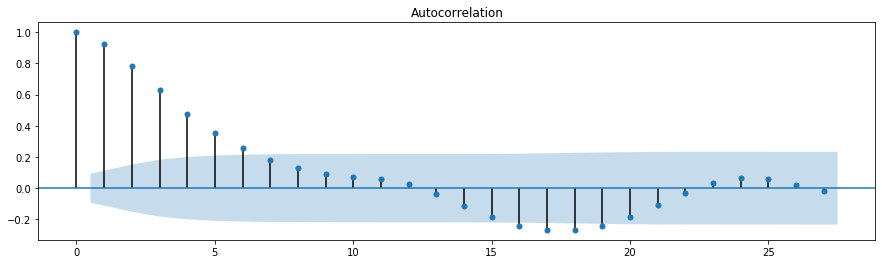

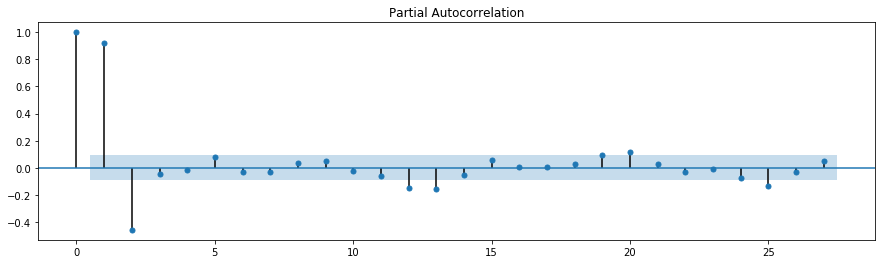

In [36]:
# subtract mean
ar_process = rec.rec.values - rec.rec.mean()

ax = plt.figure(figsize=(15,4)).gca()
ax.plot(rec.time, ar_process)
ax.set_title('AR Process')

# acf
ax = plt.figure(figsize=(15,4)).gca()
plot_acf(ar_process, ax=ax);

# pacf
ax = plt.figure(figsize=(15,4)).gca()
plot_pacf(ar_process, ax=ax);

In [67]:
# Calculate coefficients
phi_hat = fit_ar(ar_process, p=2)
constant_term = rec.rec.mean() * (1 - phi_hat.sum())
estimated_var = estimate_var(ar_process, phi_hat)
print('phi hat', phi_hat)
print('constant', constant_term)
print('estimated variance', estimated_var)


phi hat [ 1.33158739 -0.4445447 ]
constant 7.0330362670859365
estimated variance 93.25583109948623


/Users/vitoral/anaconda3/envs/mlearn/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


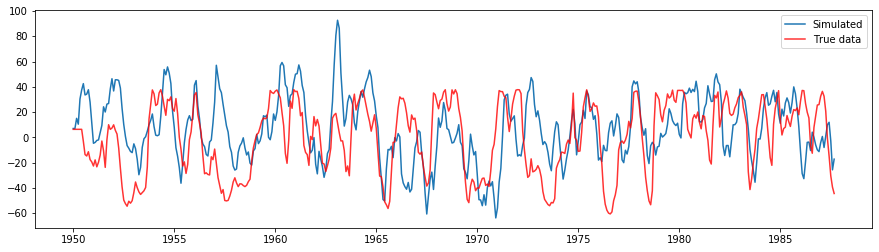

In [98]:
plt.figure(figsize=(15,4))
closer = None
param = np.inf
for _ in range(1000):
    proc = ar(phi_hat, 453, estimated_var**(1/2)) + constant_term
    error = np.sqrt(((proc-ar_process)*(proc-ar_process)).sum())
    if  error < param:
        closer = proc
        param = error
    
plt.plot(rec.time, closer, label='Simulated') 
plt.plot(rec.time,ar_process, c='r', label='True data', alpha=0.8)
plt.legend()

# Johnson and Johnson model fitting

In [100]:
jj = pd.read_csv("JohnsonJohnson.csv", index_col=0); jj.head()

,time,JJ
1,1960.00,0.71
2,1960.25,0.63
3,1960.50,0.85
4,1960.75,0.44
5,1961.00,0.61


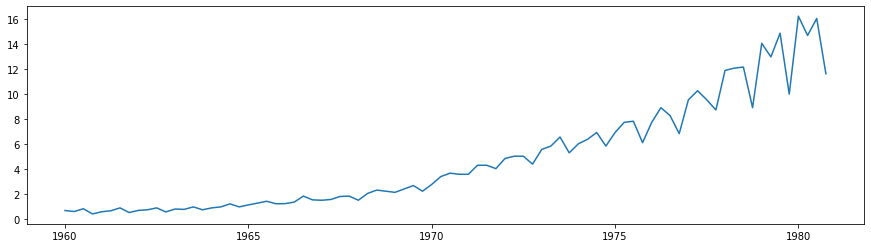

In [101]:
plt.figure(figsize=(15,4))
plt.plot(jj.time, jj.JJ)

In [133]:
jj_transf = np.diff(np.log(jj.JJ))
jj_transf = jj_transf - jj_transf.mean()

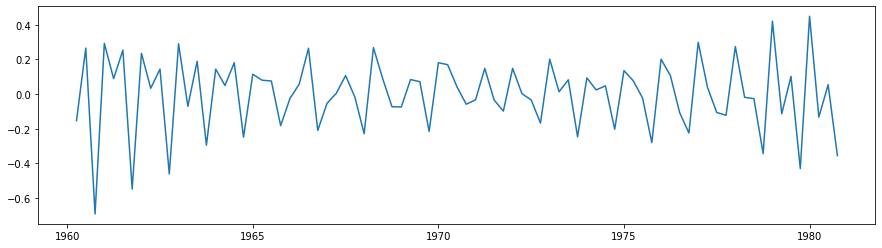

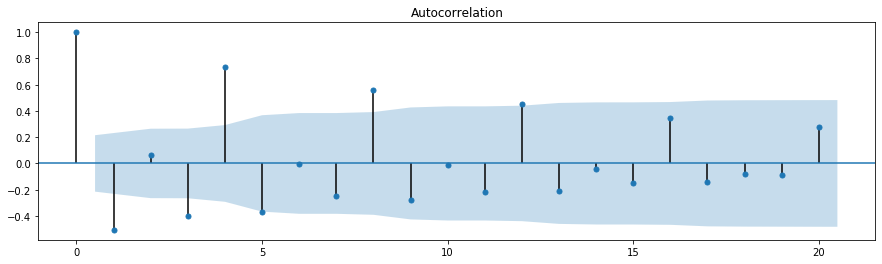

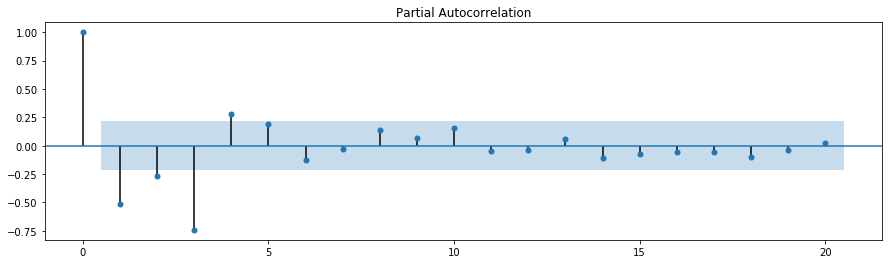

In [134]:
plt.figure(figsize=(15,4))
plt.plot(jj.time[1:], jj_transf)
ax = plt.figure(figsize=(15,4)).gca()
plot_acf(jj_transf, ax=ax);
ax = plt.figure(figsize=(15,4)).gca()
plot_pacf(jj_transf, ax=ax);
plt.show()

In [135]:
# Calculate coefficients
phi_hat = fit_ar(jj_transf, p=4)
constant_term = np.diff(np.log(jj.JJ)).mean() * (1 - phi_hat.sum())
estimated_var = estimate_var(jj_transf, phi_hat)
print('phi hat', phi_hat)
print('constant', constant_term)
print('estimated variance', estimated_var)



phi hat [-0.62934924 -0.51715263 -0.48833738  0.26512665]
constant 0.0797810030728411
estimated variance 0.014192423423442681


/Users/vitoral/anaconda3/envs/mlearn/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


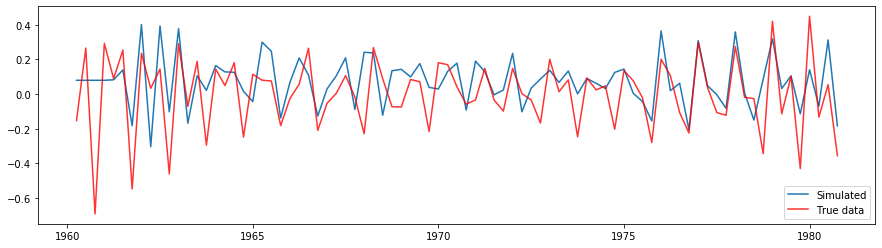

In [131]:
plt.figure(figsize=(15,4))
closer = None
param = np.inf
for _ in range(5000):
    proc = ar(phi_hat, jj_transf.size, estimated_var**(1/2)) + constant_term
    error = np.sqrt(((proc-jj_transf)*(proc-jj_transf)).sum())
    if  error < param:
        closer = proc
        param = error
    
plt.plot(jj.time[1:], closer, label='Simulated') 
plt.plot(jj.time[1:],jj_transf, c='r', label='True data', alpha=0.8)
plt.legend()